## Computer vision 2022 Assignment 3: Deep Learning for Perception Tasks

This is the coding part for the assignment 3. It is a very easy practice for the beginers to get familar with how to use deep learning frameworks.

# Question 1: A simple classifier (60%)

For this exercise, we will provide a demo code showing how to train a network on a small dataset called FashionMinst. Please go through the following tutorials first. You will get a basic understanding about how to train an image classification network in pytorch. You can change the training scheme and the network structure. Please answer the following questions then. You can orginaze your own text and code cell to show the answer of each questions.


Note: Please plot the training and testing loss curve for each experiment (2 point).


Requirement:

Q1.1 (1 point) Change the learning rate and train for 10 epochs. Fill this table:

|Lr|Accuracy|
|---|---|
|1   |      |
|0.1|          |
|0.01|         |
|0.001  |        |


Q1.2 (2 point) Report the number of epochs when the accuracy reaches 90%. If the program can not reach 90% within 100 epochs, please fill in "not converged" in the Epoch blank. Fill this table:

|Lr|Accuracy|Epoch|
|---|---|---|
|1   |      |     |
|0.1|          |    |
|0.01|         |    |
|0.001  |        |     |


Q1.3 (2 points) Compare the results in table 1 and table 2, what is your observation and your understanding of the learning rate?



Q1.4 (3 point) Suppose the given network is a base network, please calculate the trainable parameters for this given network, and report its accuracy with lr = 0.01 and 40 epochs.
Change the network structures by adding/removing layers/nodes. Report the accuracy and the parameters for each structure under the same training setting. Parameters represent the number of trainable parameters in your model, e.g. a 3 x 3 conv has 9 parameters, and a linear layer with n input nodes and m output nodes has n*m+m parameters for weights and bias.


|Structures|Accuracy|Parameters|
|---|---|---|
|Remove nodes|          ||
|Remove layers|          ||
|Base   |      ||
|Add layers|          ||
|Add nodes|         ||


Q1.5 (2 points) Choose to do one of the following two tasks:

a. Write a code to calculate the parameter and expian the code.

OR

b. Write done the process of how to calculate the parameters by hand. 


Q1.6 (1 points) What are your observations and conclusions for changing network structure?


Q1.7 (2 points) Calculate the mean of the gradients of all trainable parameters. Plot the gradients curve for the first 1000 training steps. Please use lr = 0.1. What are your observations? Note that this gradients will be saved with the training parameters automatically after you call loss.backwards(). Hint: https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html


In [63]:
import numpy as np # This is for mathematical operations

# this is used in plotting 
import matplotlib.pyplot as plt 
import time
import pylab as pl
from IPython import display

%matplotlib inline

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
#### Tutorial Code
####PyTorch has two primitives to work with data: torch.utils.data.DataLoader and torch.utils.data.Dataset. 
#####Dataset stores samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset.
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

# Download training data from open datasets. 
##Every TorchVision Dataset includes two arguments: 
##transform and target_transform to modify the samples and labels respectively.


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

We pass the Dataset as an argument to DataLoader. This wraps an iterable over our dataset and supports automatic batching, sampling, shuffling, and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

In [65]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


To define a neural network in PyTorch, we create a class that inherits from nn.Module. We define the layers of the network in the init function and specify how data will pass through the network in the forward function. To accelerate operations in the neural network, we move it to the GPU if available.

In [66]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [67]:
###Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) # 1, 0.1, 0.01, 0.001

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model’s parameters.

In [68]:
def train(dataloader, model, loss_fn, optimizer, out=None):
    size = len(dataloader.dataset)
    model.train()

    losses = []
    grads = []

    num_batch = 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        # extract gradient, calculate mean, and store
        mean_grad = []
        for name, parameter in model.named_parameters():
          if not parameter.requires_grad: continue
          val = parameter.grad.mean().item()
          mean_grad.append(val)
        
        grads.append(np.mean(mean_grad))

        optimizer.step()

        if batch % 100 == 0:
            current = batch * len(X)
            # print(f"loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")

        losses.append(loss.item())
    print('Training Error:', np.mean(losses))
    return losses, grads

In [69]:
##Define a test function
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return test_loss, correct

In [70]:
# Defining customisable Network
class NeuralNetworkv2(nn.Module):
    def __init__(self, num_nodes=512, num_layers=1):
        super(NeuralNetworkv2, self).__init__()
        self.flatten = nn.Flatten()

        layers = [nn.Linear(28*28, num_nodes), nn.ReLU()]

        for layer_idx in range(num_layers):
          layers.append(nn.Linear(num_nodes, num_nodes))
          layers.append(nn.ReLU())

        layers.append(nn.Linear(num_nodes, 10))

        self.linear_relu_stack = nn.Sequential(*layers) 

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [71]:
#Helper Methods
#Method for getting the Average for a given learning rate and number of epochs
def getAverage(metric_list, lr, total_vals):
  values = getList(metric_list, lr, total_vals)
  average_value = sum(values)/total_vals
  return average_value

#Method to get a list of metric for given number of epochs
def getList(metric_list, lr, total_vals):
  return metric_list[lr][:total_vals]

#Method to plot the training and Test Curve
def plotTrainigTestCurve(first_list, second_list, first_label, second_label, title):
  plt.plot(first_list, '--*b')
  plt.plot(second_list, '--*r')
  plt.title(title)
  plt.legend(['Training','Testing'], loc='upper right')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.show()
  return

#Method to plot the Accuracy Curve
def plotAccuracy(list_of_values, label, title):
  plt.plot(list_of_values, '--*g')
  plt.title(title)
  plt.legend(['Accuracy'], loc='upper left')
  plt.xlabel('epoch')
  plt.ylabel('Accuracy')
  plt.show()
  return

#Method to run different experiment with different learning rate, network architecture and epochs
def RunExpirement(learning_rate_list, epochs, device, num_nodes = 512, num_layers = 1):
  train_loss = {}
  test_loss = {}
  test_acc = {}
  train_grads = {}
  parameters = 0

  for lr in learning_rate_list:
    print('Running for Learning Rate', lr)
    model = NeuralNetworkv2(num_nodes=num_nodes, num_layers=num_layers).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr) 
    parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('Number of parameters', parameters)
    #Train and test the model
    train_loss[lr] = []
    test_loss[lr] = []
    test_acc[lr] = []
    train_grads[lr] = []

    for t in range(epochs):
      print(f"Epoch {t+1}\n-------------------------------")
      train_loss_epoch, mean_grads = train(train_dataloader, model, loss_fn, optimizer)
      train_loss[lr].append(train_loss_epoch)
      train_grads[lr].extend(mean_grads)

      test_loss_epoch, test_acc_epoch = test(test_dataloader, model, loss_fn)
      test_loss[lr].append(test_loss_epoch)
      test_acc[lr].append(test_acc_epoch)

    train_loss[lr] = [sum(epoch_losses)/len(epoch_losses) for epoch_losses in train_loss[lr]]

    print("Done for Learning Rate!", lr, '\n\n')
  return test_acc, parameters,train_loss, test_loss

In [72]:
#Running Network for 100 Epochs for Learning Rates [1, 0.1, 0.01, 0.001] and 100 epochs
#Training the network for different learning rates 
train_loss = {}
test_loss = {}
test_acc = {}
train_grads = {}

for lr in [1, 0.1, 0.01, 0.001]:
  print('Running for Learning Rate', lr)
  #Params for Base Network
  model = NeuralNetworkv2(num_nodes=512, num_layers=1).to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=lr) 
  print('Number of parameters', sum(p.numel() for p in model.parameters() if p.requires_grad))

  #Training for over 100 epochs and will retrieve the values for 10 epochs the same
  epochs = 100
  train_loss[lr] = []
  test_loss[lr] = []
  test_acc[lr] = []
  train_grads[lr] = []

  for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss_epoch, mean_grads = train(train_dataloader, model, loss_fn, optimizer)
    train_loss[lr].append(train_loss_epoch)
    train_grads[lr].extend(mean_grads)

    test_loss_epoch, test_acc_epoch = test(test_dataloader, model, loss_fn)
    test_loss[lr].append(test_loss_epoch)
    test_acc[lr].append(test_acc_epoch)

  train_loss[lr] = [sum(epoch_losses)/len(epoch_losses) for epoch_losses in train_loss[lr]]

  print("Done for Learning Rate!", lr, '\n\n')

Running for Learning Rate 1
Number of parameters 669706
Epoch 1
-------------------------------
Training Error: 2.255376170566087
Test Error: 
 Accuracy: 34.1%, Avg loss: 1.553257 

Epoch 2
-------------------------------
Training Error: 2.016299335814234
Test Error: 
 Accuracy: 19.9%, Avg loss: 2.125590 

Epoch 3
-------------------------------
Training Error: 1.7631722781449748
Test Error: 
 Accuracy: 19.9%, Avg loss: 1.722205 

Epoch 4
-------------------------------
Training Error: 1.7280246339627165
Test Error: 
 Accuracy: 26.7%, Avg loss: 1.660301 

Epoch 5
-------------------------------
Training Error: 1.6948472774867565
Test Error: 
 Accuracy: 25.3%, Avg loss: 1.661375 

Epoch 6
-------------------------------
Training Error: 1.6669817416906865
Test Error: 
 Accuracy: 23.9%, Avg loss: 1.682803 

Epoch 7
-------------------------------
Training Error: 1.6240473434106628
Test Error: 
 Accuracy: 26.2%, Avg loss: 1.631220 

Epoch 8
-------------------------------
Training Error: 1

## Explanations Observations and Graphs

Q1.1 (1 point) Change the learning rate and train for 10 epochs. Fill this table:

|Lr|Accuracy (%)|
|---|---|
|1   |25.33      |
|0.1|84.79          |
|0.01|80.46         |
|0.001  |63.36        |


Accuracy for Learning Rate 1, is 25.33


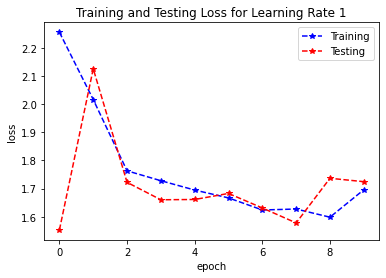

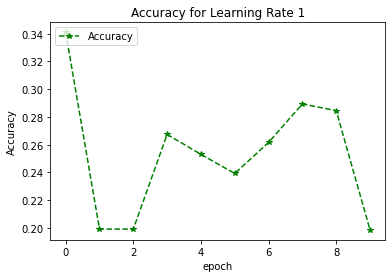




Accuracy for Learning Rate 0.1, is 84.79


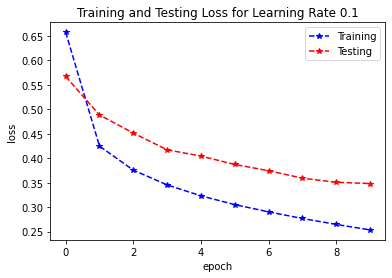

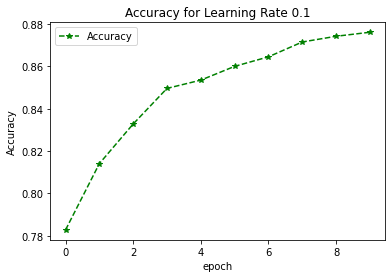




Accuracy for Learning Rate 0.01, is 80.46


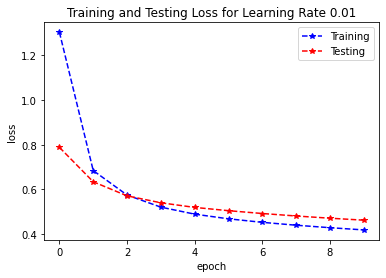

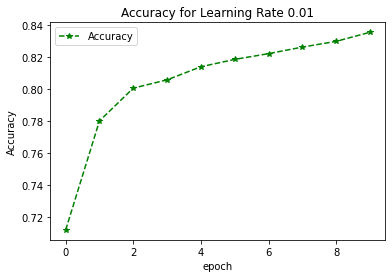




Accuracy for Learning Rate 0.001, is 63.36


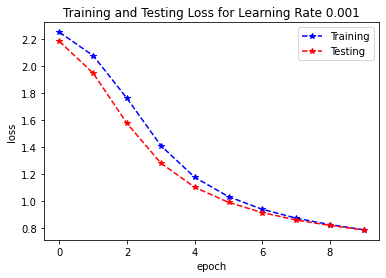

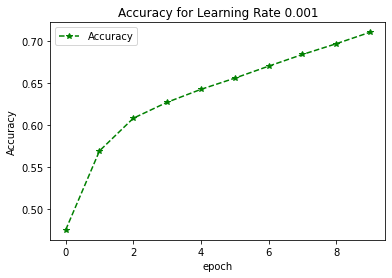

In [73]:
learning_rate = [1, 0.1, 0.01, 0.001]

#Getting train_error, test_error and accuracy
for lr in learning_rate:
   train_loss_list = getList(train_loss, lr, 10)
   test_loss_list = getList(test_loss, lr, 10)
   accuracy = float("{:.2f}".format(getAverage(test_acc, lr, 10) * 100)) #format(getAverage(test_acc, lr, 10) * 100)
   print(f'Accuracy for Learning Rate {lr}, is {accuracy}')
   plotTrainigTestCurve(train_loss_list, test_loss_list, 'Training Loss', 'Testing Loss', f'Training and Testing Loss for Learning Rate {lr}')
   plotAccuracy(getList(test_acc, lr, 10), 'Accuracy' , f'Accuracy for Learning Rate {lr}')
   print('\n\n')

Observation from the above Testing and Training loss curve for Learning rates 1, 0.1, 0.01, 0.001

1. Garphs for Learning rate 1 - It can be seen that the learning rate is too large, which means that the models is not able to converge to an an optmial solution.
2. Graph for Learning rate 0.1 - The training and testing curve is has a bigger generalisation gap between the training and testing loss and with a better accuracy than  other learning rates, it indicates that the model generalises better.
3. Graph for Learning rate 0.01 and 0.001 - The training and testing loss curves are still not stable after 100 epochs this means that the learning rate (Step sizse) is too small which implies that it will take longer (more than 100 epocsh) to converge.



Q1.2 (2 point) Report the number of epochs when the accuracy reaches 90%. If the program can not reach 90% within 100 epochs, please fill in "not converged" in the Epoch blank. Fill this table:

|Lr|Accuracy|Epoch|
|---|---|---|
|1   |18.28      | not converged     |
|0.1|87.9          |not converged    |
|0.01|86.9         |not converged    |
|0.001  |80.2        |not converged     |

Accuracy for Learning Rate 1, is 18.28


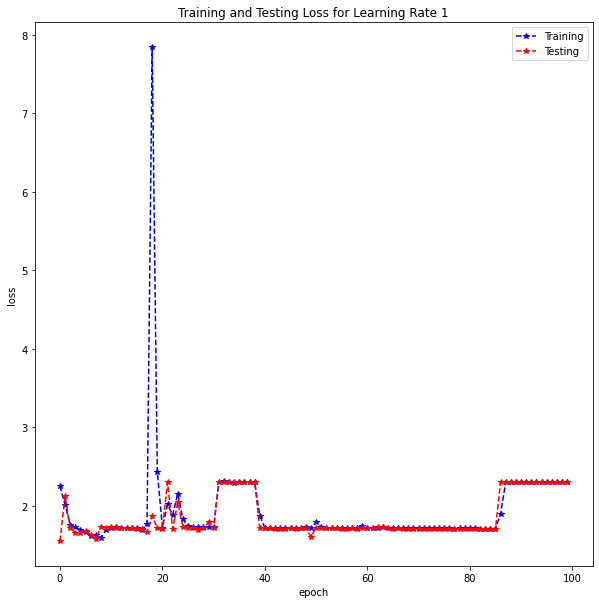

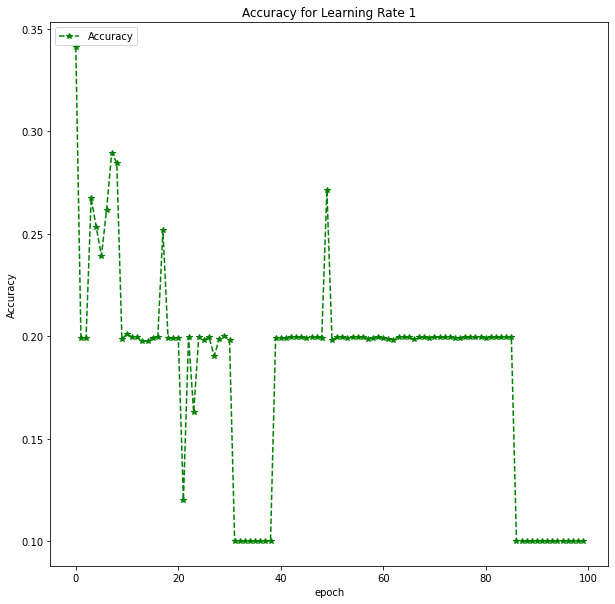




Accuracy for Learning Rate 0.1, is 87.9


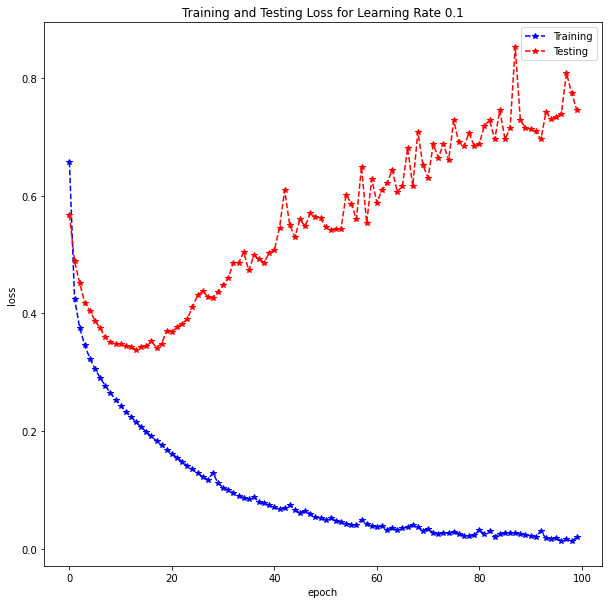

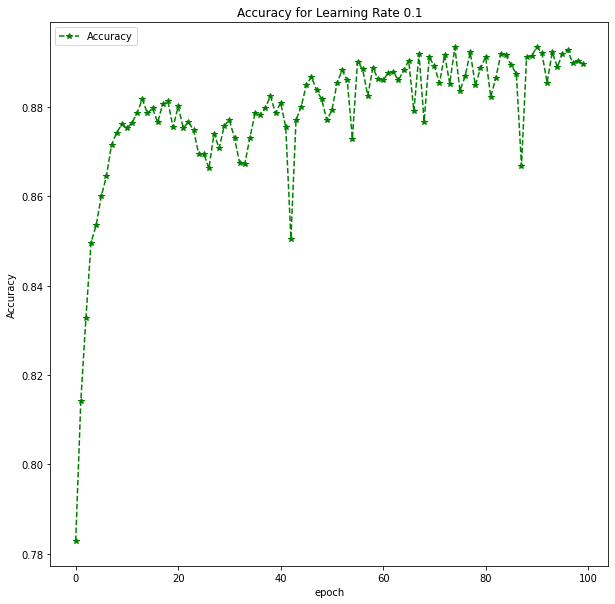




Accuracy for Learning Rate 0.01, is 86.9


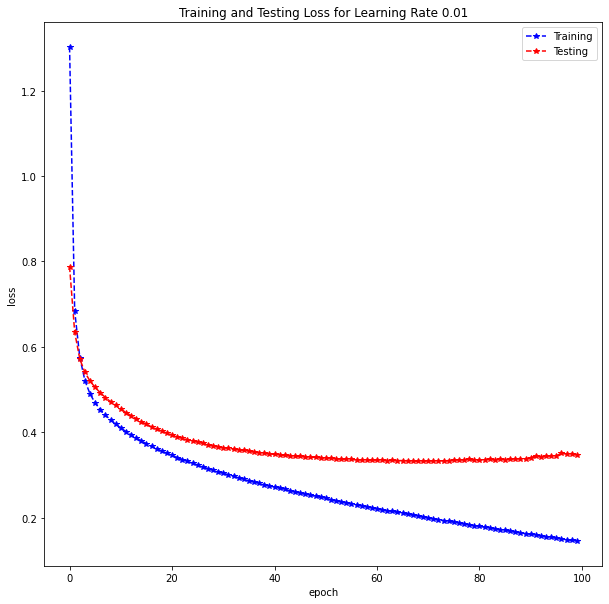

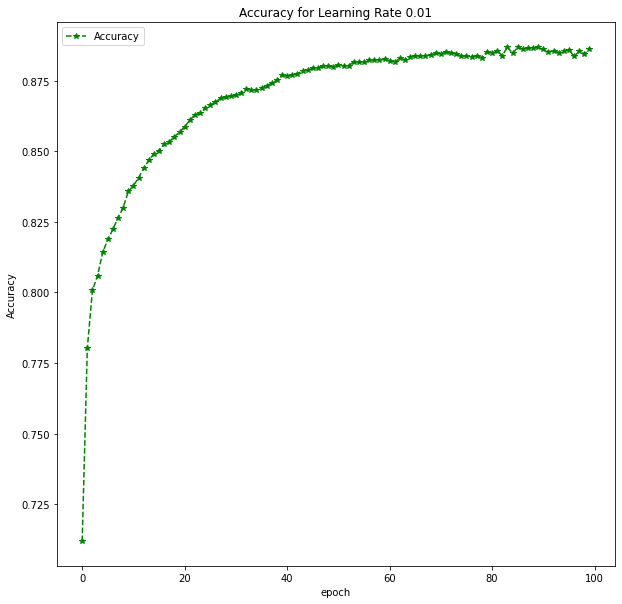




Accuracy for Learning Rate 0.001, is 80.2


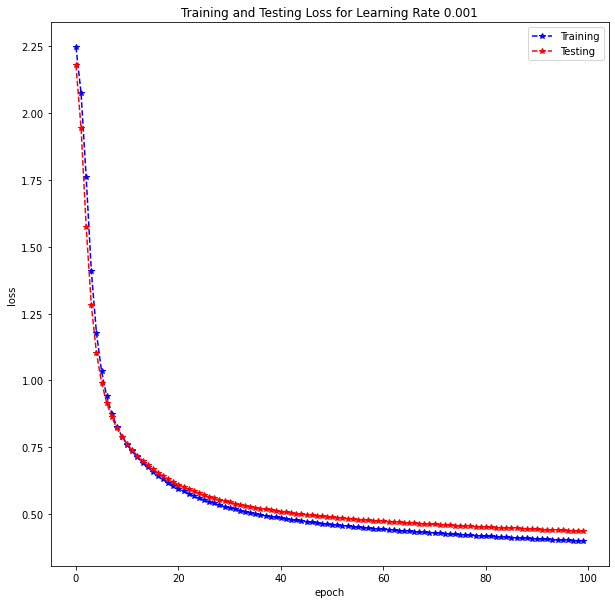

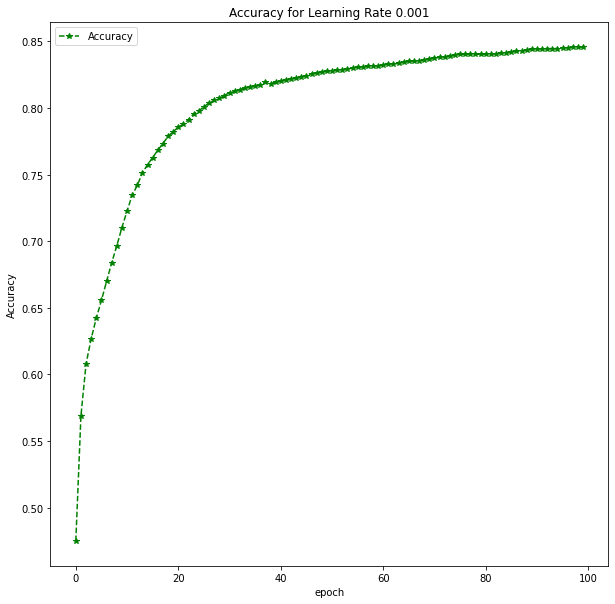

In [92]:
# test_acc[0.01]
for lr in learning_rate:
   test_loss_list = getList(test_loss, lr, 100)
   train_loss_list = getList(train_loss, lr, 100)
   accuracy = float("{:.2f}".format(getAverage(test_acc, lr, 100) * 100)) #format(getAverage(test_acc, lr, 10) * 100)
   accuracy_list = getList(test_acc, lr, 100) * 100
   print(f'Accuracy for Learning Rate {lr}, is {accuracy}')
   plotTrainigTestCurve(train_loss_list, test_loss_list, 'Training Loss', 'Testing Loss', f'Training and Testing Loss for Learning Rate {lr}')
   plotAccuracy(getList(test_acc, lr, 100), 'Accuracy' , f'Accuracy for Learning Rate {lr}')
   print('\n\n')

Results for learning rate [1, 0.1, 0.01, 0.001] running over 100 epochs

1. None of the learning rate crossed 90% Accuracy within the 100 epochs.
2. Best accuracy was achieved for learning rate 0.1
3. The train and test loss curve for learning rate 0.1 shows that it was moving towards an optimal solution and achieved 88.17% accuracy. Accuracy could have been improved if the number of epochs would have been increased or a larger learning rate would have imporved the training time.


Q1.3 (2 points) Compare the results in table 1 and table 2, what is your observation and your understanding of the learning rate?

In neural netowrrks stochastic gradient descent is used for  optimization that estimates the error and updates the weights of the model by using the back-propagation. The amount by which the weights are updated during training is known as the step size or the “learning rate.” The learning rate is a configurable hyperparameter used in the training of neural networks. Smaller learning rates require more training epochs given the smaller changes made to the weights at each update this can cause the process to get stuck.Whereas, larger learning rates result in rapid changes and require fewer training epochs. However, learning rate which is too large can cause the model to converge too quickly to a suboptimal solution.

From the table 1 and 2 following observatoin can be made:
1. As the learning rate is decreased from 1 to 0.001 the accuracy increases and then decreases. The best accuracy in both the tables is at 0.1. This signifies that the learning rate of 0.1 gives a more optimal solution than other learning rates
2. It can be seen that as the number of epoch is increased from 10 to 100 the accuracy of learning rates for 0.1, 0.01 and 0.001 increases. This is becuase the updates made to the weights are smaller and therefore requires more epochs to converge to an optimal solution. However, decreasing learning rate too much is also not good as it would increase the training time.
3. For learning rate 1 it can be seen that the accuracy remains almost the same. This is because the step size is too large and we keep jumping around the minima (optimal solution). Having a large learning rate might help to jump out of a local minima and move towards a global minima but this has its own risk. If the learning rate is too high it might not be able to converge and give an optimal solution.



Q1.4 (3 point) Suppose the given network is a base network, please calculate the trainable parameters for this given network, and report its accuracy with lr = 0.01 and 40 epochs.
Change the network structures by adding/removing layers/nodes. Report the accuracy and the parameters for each structure under the same training setting. Parameters represent the number of trainable parameters in your model, e.g. a 3 x 3 conv has 9 parameters, and a linear layer with n input nodes and m output nodes has n*m+m parameters for weights and bias.


|Structures|Accuracy|Parameters|
|---|---|---|
|Remove nodes|84.34          |269322|
|Remove layers|84.67          |407050|
|Base   |84.77      |669706|
|Add layers|61.26          |1720330|
|Add nodes|85.16         |3581962|


In [75]:
learning_rate_list = [0.01]
epochs = 40

average_acc_base = sum(getList(test_acc,0.01,epochs))/epochs
print(f'Accuracy for Base Network is {average_acc_base}')

Accuracy for Base Network is 0.8477675


#### Adding Nodes

In [76]:
#Adding Nodes
increased_nodes = 512 * 3
accuracy_add_nodes, params_add_noedes, train_add_nodes, test_add_nodes = RunExpirement(learning_rate_list, epochs, device, num_nodes = increased_nodes, num_layers = 1)

Running for Learning Rate 0.01
Number of parameters 3581962
Epoch 1
-------------------------------
Training Error: 1.1684784607084067
Test Error: 
 Accuracy: 74.2%, Avg loss: 0.735505 

Epoch 2
-------------------------------
Training Error: 0.6351586876393381
Test Error: 
 Accuracy: 79.2%, Avg loss: 0.598637 

Epoch 3
-------------------------------
Training Error: 0.5394703827178808
Test Error: 
 Accuracy: 80.5%, Avg loss: 0.550071 

Epoch 4
-------------------------------
Training Error: 0.4952989307357304
Test Error: 
 Accuracy: 81.2%, Avg loss: 0.522990 

Epoch 5
-------------------------------
Training Error: 0.46871908777939486
Test Error: 
 Accuracy: 81.8%, Avg loss: 0.504160 

Epoch 6
-------------------------------
Training Error: 0.4497640370401238
Test Error: 
 Accuracy: 82.3%, Avg loss: 0.489144 

Epoch 7
-------------------------------
Training Error: 0.4347197300653214
Test Error: 
 Accuracy: 82.8%, Avg loss: 0.476513 

Epoch 8
-------------------------------
Training E

Accuracy when increasing nodes to 1536 is 0.8516425000000002 with params 3581962 



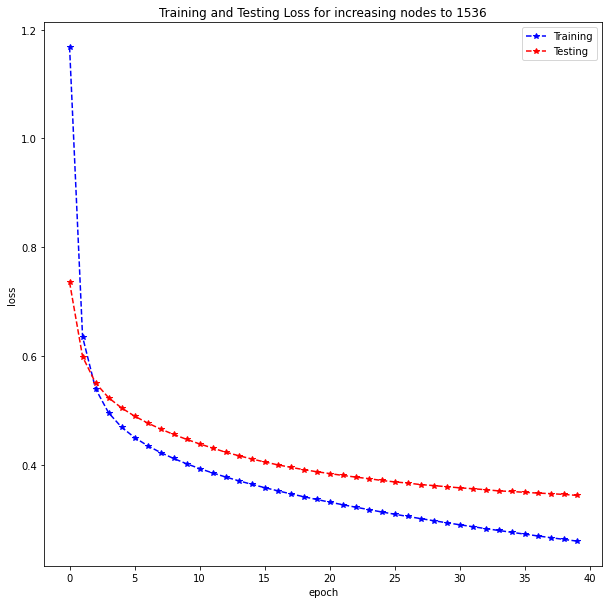

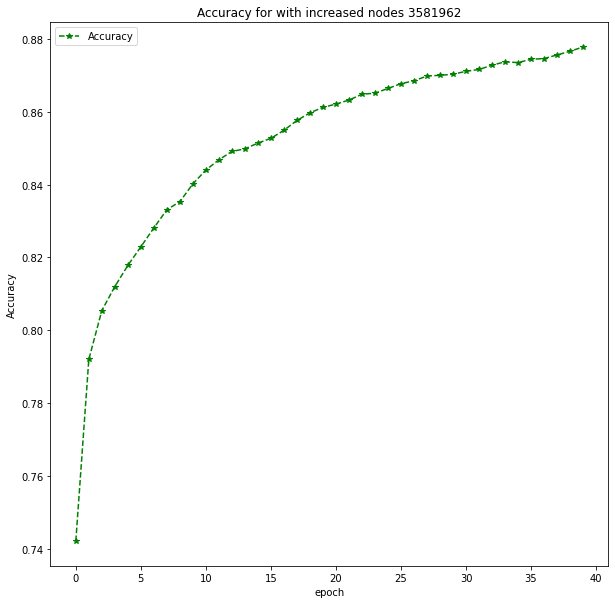

In [84]:
accuracy_mean_add_nodes = sum(accuracy_add_nodes[learning_rate_list[0]])/epochs
print(f'Accuracy when increasing nodes to {increased_nodes} is {accuracy_mean_add_nodes} with params {params_add_noedes} \n')
plotTrainigTestCurve(train_add_nodes[0.01], test_add_nodes[0.01], 'Training Loss', 'Testing Loss', f'Training and Testing Loss for increasing nodes to {increased_nodes}')
plotAccuracy(accuracy_add_nodes[learning_rate_list[0]], 'Accuracy' , f'Accuracy for with increased nodes {params_add_noedes}')

#### Removing Nodes

In [85]:
#Remove Nodes
reduced_nodes = 256
acc_remove_nodes, params_remove_nodes, train_remove_nodes, test_remove_nodes = RunExpirement(learning_rate_list, epochs, device, num_nodes = reduced_nodes, num_layers = 1)

Running for Learning Rate 0.01
Number of parameters 269322
Epoch 1
-------------------------------
Training Error: 1.3416574306325364
Test Error: 
 Accuracy: 70.5%, Avg loss: 0.812208 

Epoch 2
-------------------------------
Training Error: 0.700541394987086
Test Error: 
 Accuracy: 77.5%, Avg loss: 0.646135 

Epoch 3
-------------------------------
Training Error: 0.5827143722886978
Test Error: 
 Accuracy: 79.5%, Avg loss: 0.578784 

Epoch 4
-------------------------------
Training Error: 0.5248314768139487
Test Error: 
 Accuracy: 80.3%, Avg loss: 0.547352 

Epoch 5
-------------------------------
Training Error: 0.49261769444258735
Test Error: 
 Accuracy: 80.9%, Avg loss: 0.526362 

Epoch 6
-------------------------------
Training Error: 0.4711527380544239
Test Error: 
 Accuracy: 81.6%, Avg loss: 0.510423 

Epoch 7
-------------------------------
Training Error: 0.45476838098024763
Test Error: 
 Accuracy: 81.9%, Avg loss: 0.498184 

Epoch 8
-------------------------------
Training Er

Accuracy for nodes reduced to 256 is 0.8433975


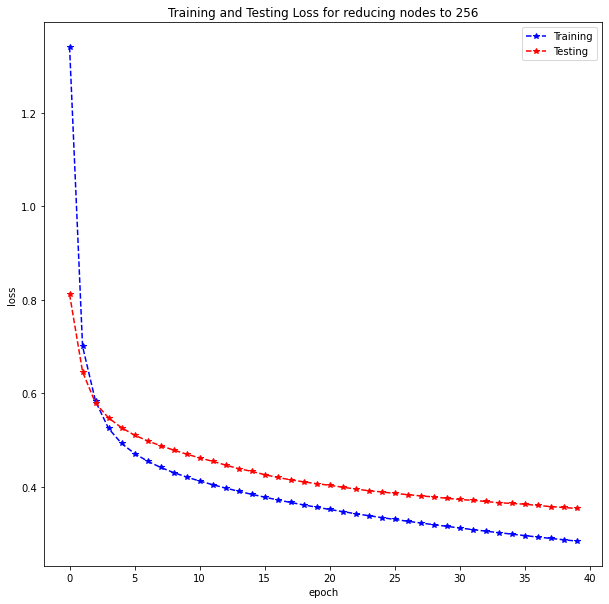

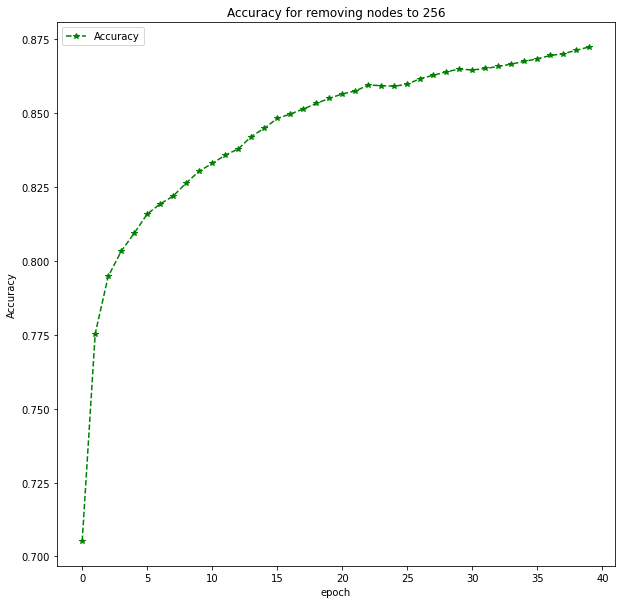

In [86]:
acc_averag_remove_nodes = sum(acc_remove_nodes[learning_rate_list[0]])/epochs
print(f'Accuracy for nodes reduced to {reduced_nodes} is {acc_averag_remove_nodes}')
plotTrainigTestCurve(train_remove_nodes[0.01], test_remove_nodes[0.01], 'Training Loss', 'Testing Loss', f'Training and Testing Loss for reducing nodes to {reduced_nodes}')
plotAccuracy(acc_remove_nodes[learning_rate_list[0]], 'Accuracy' , f'Accuracy for removing nodes to {reduced_nodes}')

#### Removing Layers

In [87]:
#Remove Layers
reduced_layers = 1 * 0 
acc_remove_layers, params_remove_layers, train_remove_layers, test_remove_layers = RunExpirement(learning_rate_list, epochs, device, num_nodes = 512, num_layers = reduced_layers)


Running for Learning Rate 0.01
Number of parameters 407050
Epoch 1
-------------------------------
Training Error: 1.1019794021461056
Test Error: 
 Accuracy: 74.5%, Avg loss: 0.742062 

Epoch 2
-------------------------------
Training Error: 0.6523614588068493
Test Error: 
 Accuracy: 79.0%, Avg loss: 0.613051 

Epoch 3
-------------------------------
Training Error: 0.564571178766456
Test Error: 
 Accuracy: 80.8%, Avg loss: 0.558196 

Epoch 4
-------------------------------
Training Error: 0.5206007519002154
Test Error: 
 Accuracy: 81.8%, Avg loss: 0.527591 

Epoch 5
-------------------------------
Training Error: 0.49349676520585506
Test Error: 
 Accuracy: 82.2%, Avg loss: 0.507564 

Epoch 6
-------------------------------
Training Error: 0.47461345440733915
Test Error: 
 Accuracy: 82.8%, Avg loss: 0.493117 

Epoch 7
-------------------------------
Training Error: 0.4602979923457479
Test Error: 
 Accuracy: 83.2%, Avg loss: 0.481930 

Epoch 8
-------------------------------
Training Er

Accuracy for reduced hidden Layers to 0 is 0.8467125 with params 407050


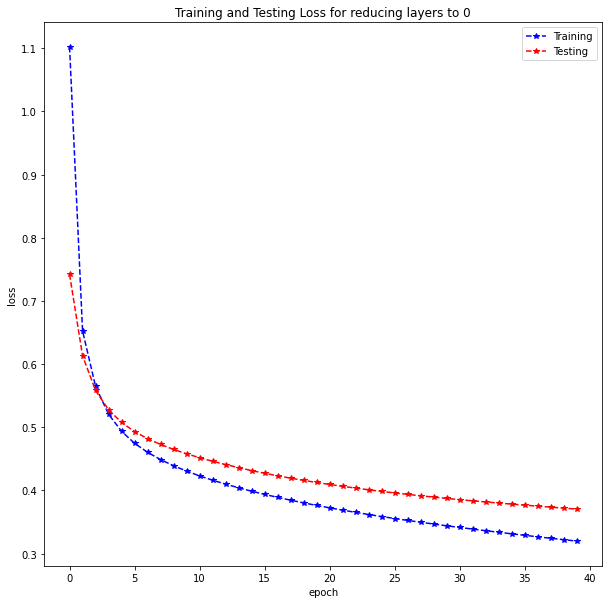

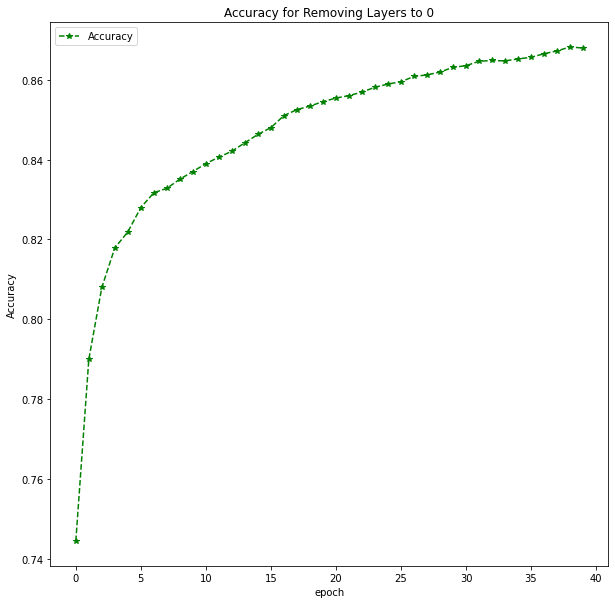

In [88]:
# acc_remove_layers, params_remove_layers
average_acc_remove_layers = sum(acc_remove_layers[learning_rate_list[0]])/epochs
print(f'Accuracy for reduced hidden Layers to {reduced_layers} is {average_acc_remove_layers} with params {params_remove_layers}')
plotTrainigTestCurve(train_remove_layers[0.01], test_remove_layers[0.01], 'Training Loss', 'Testing Loss', f'Training and Testing Loss for reducing layers to {reduced_layers}')
plotAccuracy(acc_remove_layers[learning_rate_list[0]], 'Accuracy' , f'Accuracy for Removing Layers to {reduced_layers}')

#### Adding Layers

In [93]:
#Add Layers
increased_layers = 1 * 7
acc_add_layers, params_add_layers, train_add_layers, test_add_layers = RunExpirement(learning_rate_list, epochs, device, num_nodes = 512, num_layers = increased_layers)

Running for Learning Rate 0.01
Number of parameters 2245642
Epoch 1
-------------------------------
Training Error: 2.3027053883334974
Test Error: 
 Accuracy: 10.0%, Avg loss: 2.302525 

Epoch 2
-------------------------------
Training Error: 2.3025617846039568
Test Error: 
 Accuracy: 10.0%, Avg loss: 2.302452 

Epoch 3
-------------------------------
Training Error: 2.302489134802747
Test Error: 
 Accuracy: 10.0%, Avg loss: 2.302379 

Epoch 4
-------------------------------
Training Error: 2.3024082168587237
Test Error: 
 Accuracy: 10.3%, Avg loss: 2.302289 

Epoch 5
-------------------------------
Training Error: 2.3023066693531677
Test Error: 
 Accuracy: 14.6%, Avg loss: 2.302174 

Epoch 6
-------------------------------
Training Error: 2.3021639364360493
Test Error: 
 Accuracy: 16.2%, Avg loss: 2.302004 

Epoch 7
-------------------------------
Training Error: 2.3019600908385156
Test Error: 
 Accuracy: 16.1%, Avg loss: 2.301751 

Epoch 8
-------------------------------
Training Err

Accuracy for increased hidden Layers to 7 is 0.6125825 with params 2245642


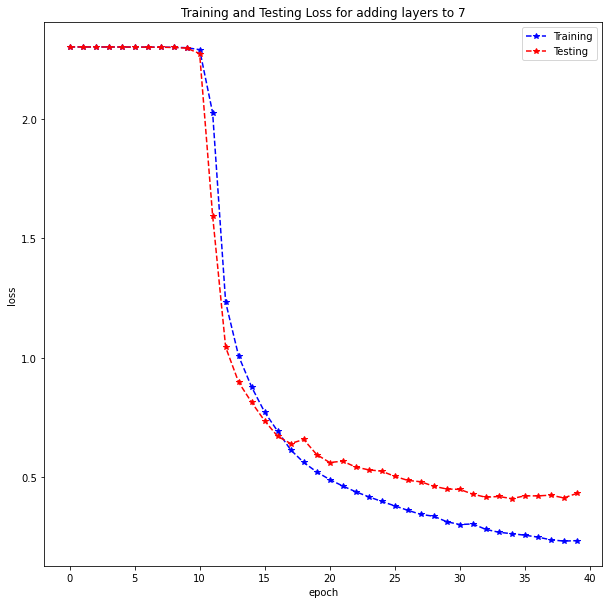

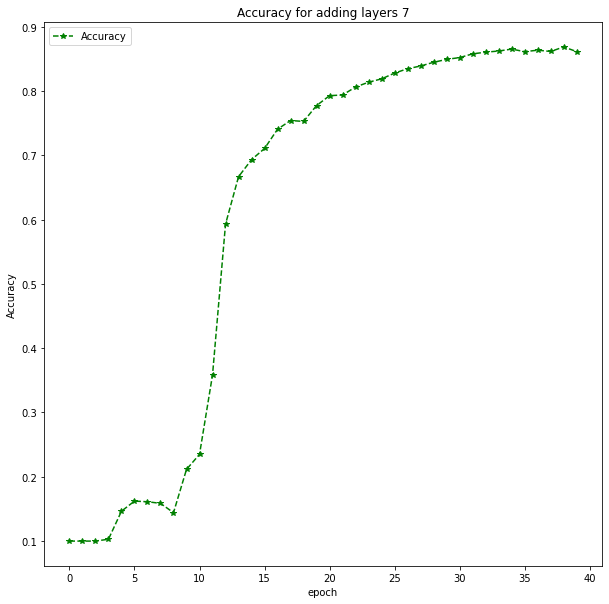

In [95]:
# acc_add_layers, params_add_layers
average_acc_add_layers = sum(acc_add_layers[learning_rate_list[0]])/epochs
print(f'Accuracy for increased hidden Layers to {increased_layers } is {average_acc_add_layers} with params {params_add_layers}')
plotTrainigTestCurve(train_add_layers[0.01], test_add_layers[0.01], 'Training Loss', 'Testing Loss', f'Training and Testing Loss for adding layers to {increased_layers}')
plotAccuracy(acc_add_layers[learning_rate_list[0]], 'Accuracy' , f'Accuracy for adding layers {increased_layers}')

Q1.5 (2 points) Choose to do one of the following two tasks:

b. Write done the process of how to calculate the parameters by hand. 


For a fully connected network the number of trainable parameteres can be be comptuted by (n + 1) * m. Where n is the number of input units and m is the number of output units and + 1 term in the equation takes care of the bias term. The number of trainable parameters are computed for input, output and all the hidden layers. For example calcuating the number of trainable parameters in the base network provided in this notebook, which has one input layer, one hidden layer and one output layer

Parameteres in 
1. Input Layer: Input layer has 28x28 input and 512 output units
  => (28 x 28 + 1 ) * 512 = (784 + 1 ) * 512 =401920
2. Hidden Layer: Hidden layer has 512 input and 512 output units
  => (512 + 1) * 512 = 262656
3. Output Layer: Output Layer has 512 input and 10 output units
  => (512 + 1) * 10 = 5130

|Layer | params (n +1) * m
|---|---|
|input layer  |401920      |
|first hidden layer|262656          |
|ouptut layer |5130         |

Total Trainable Parameters : 669706

In a simillar way trainable parameters can be calculated for fully connected networks with more than one hidden layer. Parameters for each hidden layer is computed separately and summed together with the input and output layer.





Q1.6 (1 points) What are your observations and conclusions for changing network structure?


A network with enough nodes in the single hidden layer can learn to approximate any mapping function and increasing the depth increases the capacity of the model. Training deep models can be computationally more efficient than training a single layer network with a vast number of nodes

It can be seen from the experiments done in Q1.4 that as we increase the number of nodes and hidden layer the accuracy increases, this showcases that the base model is not able to understant the complete information presented in the dataset. It can be also seen from the training and testing loss curves that the models could  still train for couple more epochs to get to the optimal solution. However, increasing the numbers of layers too much increases the complexity of the model which captures more details from the training data leading to overfitting as can be seen when increasing the number of hidden layers to 7.

On the contrary, as the nodes and layers are removed the prediction is comparable to the base network. This indicates that the network is still able to learn as much as the base network even with the a lower number of nodes or layers. This appears to underfit the dataset and therefore the width(nodes) and depth(layers) could be increased.

Q1.7 (2 points) Calculate the mean of the gradients of all trainable parameters. Plot the gradients curve for the first 1000 training steps. Please use lr = 0.1. What are your observations? Note that this gradients will be saved with the training parameters automatically after you call loss.backwards(). Hint: https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html


In [80]:
def plotGradient(grad_list, title):
  plt.plot(grad_list, '--b')
  plt.rcParams["figure.figsize"] = (10,10)
  plt.title(title)
  plt.legend(['gradient'], loc='upper right')
  plt.xlabel('Training Steps')
  plt.ylabel('Gradient')
  plt.show()
  return

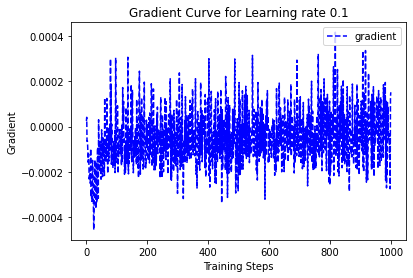

In [81]:
gradient_list = train_grads[0.1][:1000]
plotGradient(gradient_list, 'Gradient Curve for Learning rate 0.1')

From the gradient curve it can be seen that the average gradient eventually decreases as the timestep increases. This indicates that the weights and bias values in the loss function are moving towards an optmial values. For comparison the gradient curve for learning rate 1 and 0.001 are showcased below. 

It can be seen that for learning rate 1 is too big as the average gradient shows sharp increase after certain invertals. This shows that the step size is too large and the step size is making the value of weight and bias jump around the minima.

For learning rate 0.001, it can be seen that the gradients are gradually decreasing but the rate is slower than the learning rate 0.1. This indicates that the step size 0.001 is too small and would take a longer time to converge.

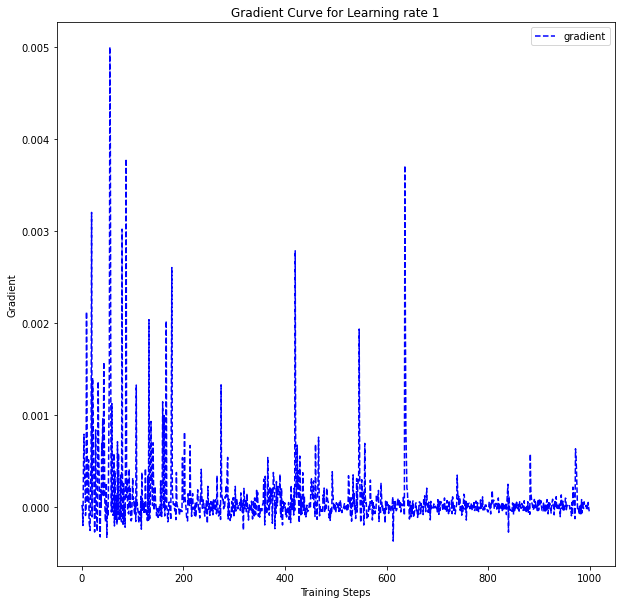

In [82]:
gradient_list_2 = train_grads[1][:1000]
plotGradient(gradient_list_2, 'Gradient Curve for Learning rate 1')

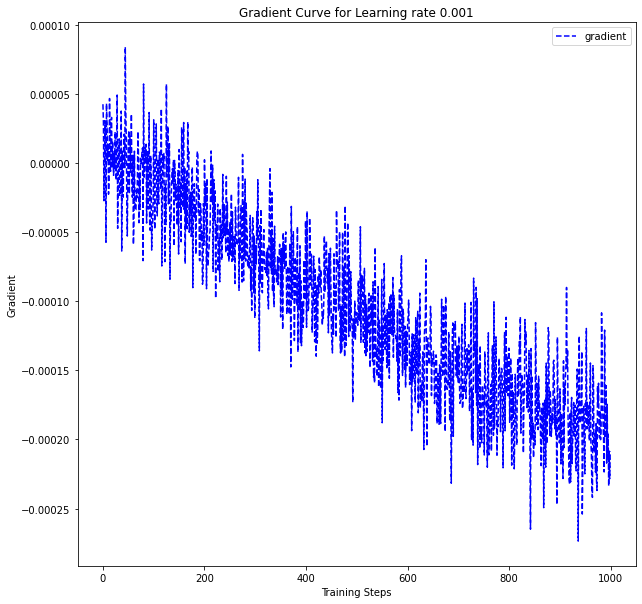

In [83]:
gradient_list_3 = train_grads[0.001][:1000]
plotGradient(gradient_list_3, 'Gradient Curve for Learning rate 0.001')

# Question 2: Presentation for Practical Applications (40%)
This is a group work. Each group needs to do a presentation at week 12. For each group, they will have around 15 minutes to present and 5 minutes to answer questions. Please submit your slides in myUni system.

Look for a typical computer vision problem, such as:
a. removing noise on the image

b. increasing the resolution of the image

c. identifying objects in the image

d. segmenting the area to which the image belongs

e. estimating the depth of an object

f. estimating the motion of two object in different frames

g. generating colors for grey scale images

h. Others...

Discuss possible applications of this problem in life, e.g. image editing systems in your phone, improved quality of the old film, sweeping robot avoiding obstacles, unlocks the face of the mobile phone, identifies the cancer area according to the medical scan image, determines the identity according to the face, identifies the trash can on the road, and the detection system tracks the target object, etc.

Your presentation should include:
1. Introduction of this problem, e.g.,

    The defination of the problem, the application of the problem and the research chanllenge of this problem
2. Literature review

    a. Briefly describe a feasible solution from the literatures based on image processing and traditional machine learning algorithms.
    
    b. Briefly describe a feasible deep learning-based solution from the literatures.
3. Discussions

    Compare the advantages and disadvantages of the two options.

